# Word2Vec Skip-gram Algorithm with Negative Sampling Training Procedure

*Antonio Buono, 2023*

## Introduction

In the context of Natural Language Processing (NLP), Word2Vec is a class of models for computing continuous vector representation of words, specifically designed for large unlabeled datasets. </br> Since its proposal in 2013, and although its relative architectural simplicity, it has proven capable of capturing precise syntactic and semantic word relationships and traslate them in the language of vector spaces. In the introductory article (by Mikolov et al. at Google Inc.) two different model architectures are proposed: Continuous Bag of Words (CBOW) and Skip-gram; this notebook will focus on the latter, implenting it by making use of the PyTorch API. Later refinements of the Skip-gram model (described in a subsequent article by the same authors) introduced the Negative Sampling procedure, which makes use of a different loss function and greatly increases both efficiency and accuracy of the results.

## The Skip-gram Architecture

The basic assumption of Word2Vec is that semantically related words tend to appear in the immediate vicinity of one another inside an organized corpus of text. Given an input word, the goal of Skip-gram is to predict the probabilities that other words in the vocabulary are somewhat similar to the given one; the words for which the highest probability has been computed are called **context words** and they should correspond to the ones that appear more frequently nearby the input word. 


<div>
<img src="skipgram_mikolov.png", width="300"/>
</div>

In order to train such a model we will need pairs `(word, context)` as examples. To generate these samples we define a **window of context** of size *C* from which we will extract the closest context words from a center. In the following picture we can see an example of sample extraction with *C=2*.

<div>
<img src="window.png", width="500"/>
</div>

Once samples are obtained, single words are vectorized through One-Hot encoding and then passed to the Skip-gram neural network for training: it is a shallow two layer fully connected feedforward neural network with N linear neurons in the hidden layers and a softmax classifier on the output.<br>
What we really are after, however, is the vector representation of the input word, which is given by the hidden layer N-dimensional vector produced by the input when multiplied with the trained weight matrix.<br>
* Input Vector: One-Hot Encoded Vx1 vector (V:vocabulary size)
* Input Weight Matrix: VxN
* Hidden layer: Nx1 vector (N:**embedding dimension**)
* Output Weight Matrix: NxV
* Softmax between V different classes

<div>
<img src="nn1.png", width="500"/>
</div>

Since our input is an high-dimensional One-Hot vector, and all it does under matrix multiplication is select the matrix row corresponding to its non-zero index, it is computationally more efficient to replace the input layer with a **look-up table**, which stores, in its rows, all the hidden layer representation for each word. This is done, in PyTorch, via the `Embedding` module, which trains like any other weight matrix. In this way we can identify each input word with an integer ranging from 0 to *V-1* to get the input vector representation of that specific word.

<div>
<img src="lookuptable.png", width="500"/>
</div>

Let's see more in detail how the Skip-gram NN transforms the input and context pairs from our training set and derive our loss function.

<div>
<img src="neuralnetwork.png", width="300"/>
</div>

For word *k* we have:

$$
\mathbf{h}=\mathbf{W}^T\mathbf{x}^{[k]} = \mathbf{W}_{(k,:)}:=\mathbf{v}_{w_{k}}
$$

This is the word embedding for word k of our vocabulary, which we are interested in, and the one we will extract from the k-th row our input lookup table. We'll refer to this vector as **input vector**.<br>
Now, to compute the probabilities of word c being a context word for word k we need to apply softmax to the output of the last layer:

$$
u_{c,k} = (\mathbf{W'}^{T}\mathbf{h})_c = \mathbf{h}^T\mathbf{W'}_{(:,c)} := \mathbf{h}^T\mathbf{v'}_{w_c}
$$

***v'*** describes another vector representation, this time for word c, which corresponds to the c-th column of the second weight matrix. We refer to this vector as **output vector**.<br>
Since every context for which we want to compute probability has a one-to-one correspondance with the second weight matrix, we can introduce a second **context lookup table** which prevents us from performing matrix multiplication. 

$$
p(c|k) = y_{c,k} = \frac{\exp(u_{c,k})}{\sum_{c'=1}^{C}\exp(u_{c',k})} = \frac{\exp(\mathbf{v'}_c \cdot \mathbf{v}_k)}{\sum_{c'=1}^{C}\exp(\mathbf{v'}_{c'} \cdot \mathbf{v}_k)}
$$

<div>
    <img src="contextmatrix.png", width="500"/>
</div>

Now we'll calculate our loss function using maximum likelihood:

\begin{align}
\underset{\theta}{\operatorname{argmax}} p(C|V;\theta) &= \underset{\theta}{\operatorname{argmax}} \underset{(k,c)\in D}{\prod} p(c|k;\theta)\\ 
&= \underset{\theta}{\operatorname{argmax}}\underset{(k,c)\in D}{\prod}\frac{\exp(\mathbf{v'}_c \cdot \mathbf{v}_k)} {\underset{c'\in C}{\sum}\exp(\mathbf{v'}_{c'}\cdot \mathbf{v}_k)}\\
&= \underset{\theta}{\operatorname{argmax}}\underset{(k,c)\in D}{\sum}\big( \mathbf{v'}_c \cdot \mathbf{v}_k - \log \underset{c'\in C}{\sum}\exp(\mathbf{v'}_{c'}\cdot \mathbf{v}_k) \big) = \underset{\theta}{\operatorname{argmin}} J(\theta)
\end{align}

Computations using this loss function can be expensive because of the last term which consists of a sum over a possibly very large set of words. One way to address this problema is to introduce a technique called **negative sampling**.

## Negative Sampling

To derive the new loss function and procedure we start by indicating the probability that a pair (k,c) belongs to the dataset D as:

$$
p(D=1|k,c)
$$

Conversely, the probability that the given pair of words are not related in the corpus is given by: 


$$
p(D=0|k,c)=1-p(D=1|k,c)
$$

Then what we want to maximize is: 

\begin{align}
\underset{\theta}{\operatorname{argmax}} p(D=1|k,c;\theta) &= \underset{\theta}{\operatorname{argmax}} \underset{(k,c) \in D}{\sum}\log p(D=1|k,c;\theta)\\ &= \underset{\theta}{\operatorname{argmax}}\underset{(k,c) \in D}{\sum}\log\frac{1}{1+\exp(-\mathbf{v'}_c \cdot \mathbf{v}_k)}
\end{align}

This objective has a trivial solution if we set $$\mathbf{v'}_c=\mathbf{v}_k$$ for all *c*,*k* and we make sure that their product is equal to a sufficiently large number K (in practice it has to be around 40).

We need a mechanism that prevents all the vectors from having the same value by disallowing some (k,c) combinations. We do this by presenting the model (k,c) pairs for which p(D=1|k,c) must be low, i.e. pairs that don't appear in D. At this scope we introduce a new "negative" dataset D' which only contains all incorrect samples.

\begin{align}
\underset{\theta}{\operatorname{argmax}}\underset{(k,c) \in D}{\prod}p(D=1|k,c;\theta)\underset{(k,c) \in D'}{\prod}p(D=0|k,c;\theta)
&=\underset{\theta}{\operatorname{argmax}}\underset{(k,c) \in D}{\prod}p(D=1|k,c;\theta)\underset{(k,c) \in D'}{\prod}\big[1-p(D=1|k,c;\theta)\big]\\
&=\underset{\theta}{\operatorname{argmax}}\underset{(k,c) \in D}{\sum}\log\frac{1}{1+\exp(-\mathbf{v'}_c \cdot \mathbf{v}_k)}+ \underset{(k,c) \in D'}{\sum}\log \Big(1-\frac{1}{1+\exp(-\mathbf{v'}_c \cdot \mathbf{v}_k)}\Big)\\
&=\underset{\theta}{\operatorname{argmax}}\underset{(k,c) \in D}{\sum}\log\sigma(\mathbf{v'}_c \cdot \mathbf{v}_k)+\underset{(k,c) \in D'}{\sum}\log\sigma(-\mathbf{v'}_c \cdot \mathbf{v}_k)
\end{align}

Our loss function is then defined by the following:

---
$$
J = -\underset{(k,c) \in D}{\sum}\log\sigma(\mathbf{v'}_c \cdot \mathbf{v}_k)-\underset{(k,c) \in D'}{\sum}\log\sigma(-\mathbf{v'}_c \cdot \mathbf{v}_k)
$$
---

Here we present the loss for the entire corpus D ∪ D′, while Mikolov et al. present it for one example (k,c) ∈ D and
n examples (k, c') ∈ D′, following a particular way of constructing D′. <br>
Specifically with negative sampling of n, Mikolov et al. constructed D' in such a way that it is n times larger than D.<br> So for each (k, c) ∈ D, *n* samples (k, c<sub>1</sub>), . . . (k, c<sub>n</sub>) are extracted, each one according to its unigram distrbution raised to the 3/4th power.

## Implementation

### Preprocessing


Sentences and words are extracted from the first 10<sup>8</sup> bytes of the english Wikipedia dump (https://mattmahoney.net/dc/textdata.html).

In [2]:
#reading data from enwiki8
text8 = open('text8/text8', encoding='utf8')
text = text8.read()

print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


In [3]:
import re
from collections import Counter

def preprocess(text):
    #replace punctuation with tokens
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace(':', ' <COLON> ')
    
    words = text.split()
    
    #remove words with 5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]
    
    return trimmed_words


def create_lookup_tables(words):
    # create lookup tables for vocabulary (mappings)
    #:param words: input list of words
    #:return: two dictionaries: vocab_to_int and int_to_vocab
    
    word_counts = Counter(words)
    #sorting words from most to least frequent in text occurences
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    #create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    
    return vocab_to_int,int_to_vocab

In [4]:
words = preprocess(text)

print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [5]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)

int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


In [6]:
print('Total number of words:', len(words))
print('Total number of unique words:', len(set(words)))

Total number of words: 16680599
Total number of unique words: 63641


Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called **subsampling** by Mikolov. For each word  *w<sub>i</sub>* in the training set, we'll discard it with probability given by:

$$
P(w_i) = 1- \sqrt{\Big(\frac{t}{f(w_i)}\Big)}
$$

where  *t* is a threshold parameter and  *f(w<sub>i</sub>)* is the frequency of word  w<sub>i</sub> in the total dataset.

In [7]:
#SUBSAMPLING
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0]) token/token count

total_count = len(int_words)
freqs = {word : count/total_count for word, count in word_counts.items()}
p_drop = {word : 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}

#discard
train_words = [word for word in int_words if random.random() > p_drop[word]]

print(train_words[:30])
print('')
print(len(train_words))

[5233, 3133, 155, 10571, 27349, 15067, 58112, 190, 10712, 1324, 2731, 3672, 2757, 7088, 5233, 1052, 44611, 602, 1134, 2621, 8983, 279, 4186, 5233, 1818, 7573, 11064, 7088, 20299, 53721]

4627031


In [8]:
#MAKING BATCHES

#this function returns the context words for a specific index word 
def get_target(words, idx, window_size=5):
    
    R = np.random.randint(1, window_size+1) #randon no. of words before and after the index to select
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R 
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [9]:
#generator of word batches as a tuple (input,targets)

def get_batches(words, batch_size, window_size=5):
    
    n_batches = len(words)//batch_size
    words = words[:n_batches*batch_size] #only full batches
    
    for idx in range(0,len(words),batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [10]:
## VALIDATION: we'll use this function to check most similar words to random words as the model trains 

def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    
    embed_vectors = embedding.weight #embedding is a pytorch embedding module
    
    #magnitude of embedding vectors
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    #pick N words from (0,window) and (1000,1000+window)
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
    
    return valid_examples, similarities

### Model definition

In [11]:
import torch
from torch import nn 
import torch.optim as optim

In [12]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        #define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        #initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1,1)
        self.out_embed.weight.data.uniform_(-1,1)
        
    def forward_input(self, input_words):
        #return input vector embeddings
        input_vector = self.in_embed(input_words)
        return input_vector

    def forward_output(self, output_words):
        #return output vector embeddings
        output_vector = self.out_embed(output_words)
        return output_vector
    
    def forward_noise(self, batch_size, n_samples):
        if self.noise_dist is None:
            #sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        
        else:
            noise_dist = self.noise_dist
        
        #sample words from noise distribution
        noise_words = torch.multinomial(noise_dist, batch_size*n_samples, replacement=True)
        device = 'cuda' if model.out_embed.weight.is_cuda else 'cpu'
        noise_words = noise_words.to(device)
        
        noise_vector = self.out_embed(noise_words).view(batch_size,n_samples, self.n_embed)
        
        return noise_vector

In [13]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input_vectors, output_vectors, noise_vectors):
        batch_size, embed_size = input_vectors.shape
        #input vectors sould be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        #output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        out_loss = torch.bmm(output_vectors,input_vectors).sigmoid().log()
        
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)
        
        return -(out_loss + noise_loss).mean()

### Training

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#get noise distribution using word frequencies calculated earlier
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75))) 

#instantiating the model
embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

#using the loss we defined
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.003)

print_every = 1500
steps = 0
epochs = 5

for e in range(epochs):
    #getting (input,target) batches
    for input_words, target_words in get_batches(train_words,512):
        steps +=1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        #input, output and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)
        
        #negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #loss stats
        if steps % print_every == 0:
            print('Epoch: {}/{}'.format(e+1, epochs))
            print('Loss: ', loss.item())
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _ , closest_idxs = valid_similarities.topk(6)
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + "|" + ','.join(closest_words))
            
            print('...\n')
            

Epoch: 1/5
Loss:  6.790860176086426
seven|the,and,ship,zero,of
if|ce,reversed,eukaryotes,marketed,reece
of|the,and,in,requires,relatives
eight|the,in,flavoring,zero,of
about|baptist,wales,poems,of,richer
united|notice,bass,thickened,cylindrical,using
its|the,households,toe,a,rotterdam
see|frontiers,weak,burrows,rated,lunch
mainly|ancient,dougherty,magazine,adad,pioneered
operating|embedded,impasse,possesses,boosting,leftrightarrow
pre|banting,patrick,gaud,nets,it
consists|conquered,stearic,personhood,article,provers
heavy|prevention,machines,musketeers,september,antioch
arts|closes,approval,serpents,aisle,rhythm
except|oldcastle,players,followers,alomar,dividing
powers|veto,pampa,chernobyl,jurists,totalitarian
...

Epoch: 1/5
Loss:  5.012263774871826
during|curling,in,burns,believers,five
not|in,the,of,and,to
there|to,as,two,a,by
or|in,the,to,a,and
be|to,in,a,is,the
united|notice,the,eight,two,nine
state|by,limit,ghazni,tops,privatized
known|of,the,to,in,by
hold|campus,crown,psychedeli

Epoch: 3/5
Loss:  2.5220775604248047
three|four,eight,five,seven,zero
by|the,that,s,as,to
was|his,later,the,wife,he
up|down,side,into,would,made
eight|four,six,one,seven,three
known|the,and,of,as,also
new|york,of,university,eight,st
for|a,also,to,as,and
nobel|prize,laureate,physicist,mathematician,physiology
grand|knights,district,defeated,again,duchy
operating|os,microsoft,unix,linux,computers
report|health,reports,agency,journal,research
event|cosmological,horizon,events,observer,bang
test|testing,tests,program,agent,software
woman|son,her,married,female,women
paris|de,la,le,sur,jean
...

Epoch: 3/5
Loss:  2.312138795852661
th|century,four,bc,centuries,was
be|can,must,any,not,is
over|zero,the,rate,five,was
had|was,after,the,were,ruled
it|be,this,that,which,not
two|zero,one,four,eight,three
used|use,or,compound,is,uses
been|the,was,have,early,found
joseph|james,william,robert,actor,david
issue|issues,powers,reform,political,proposals
stage|actors,performances,audience,songwriters,tour

Epoch: 5/5
Loss:  2.246790885925293
but|that,to,would,it,the
who|had,was,he,him,that
history|historical,association,external,references,university
by|the,s,of,in,and
also|and,with,a,an,as
six|one,four,eight,five,seven
use|used,uses,common,such,similar
his|he,him,was,career,in
marriage|marry,daughter,married,husband,marriages
numerous|including,also,collection,among,many
pope|papal,pius,archbishop,church,bishops
heavy|metal,heavily,armoured,artillery,armored
placed|used,the,hand,with,usually
mathematics|mathematical,mathematicians,algebra,theorems,study
something|know,you,find,too,really
behind|world,dome,to,leaving,end
...

Epoch: 5/5
Loss:  2.3552918434143066
will|be,we,must,can,if
most|have,are,many,the,were
use|used,uses,systems,similar,as
many|most,some,these,are,including
there|are,not,example,is,number
united|states,commonwealth,civil,u,international
a|an,and,in,the,as
known|of,in,the,as,which
centre|manchester,london,station,city,cities
bible|biblical,testament,hebrew,scripture,

In [15]:
torch.save(model, 'SkGv1.zip')

In [14]:
model = SkipGramNeg(len(vocab_to_int), 300)
model = torch.load('SkGv1.zip')
model.eval()

SkipGramNeg(
  (in_embed): Embedding(63641, 300)
  (out_embed): Embedding(63641, 300)
)

### Visualization

To give a qualitative feeling of the goodness of the embeddding, the following toy example is presented:

In [116]:
my_words = []
for word in ['pacman', 'videogame','yellow']:
    my_words.append(vocab_to_int[word])
print(my_words)

[60251, 20955, 2457]


In [117]:
my_vectors = []
for word in torch.LongTensor(my_words):
    my_vectors.append(model.in_embed(word))

In [118]:
def similarity(v,w): #similarity between two words
    mod_v = torch.linalg.vector_norm(v)
    mod_w = torch.linalg.vector_norm(w)
    return torch.matmul(v,w)/(mod_v*mod_w) 

In [119]:
cross_matrix = []
for v in my_vectors:
    for w in my_vectors:
        cross_matrix.append(float(similarity(v,w)))
cross_matrix = np.array(cross_matrix)
cross_matrix = cross_matrix.reshape(3,3)
print(cross_matrix)

[[ 0.99999994  0.1637316   0.07532616]
 [ 0.1637316   1.00000012 -0.01593503]
 [ 0.07532616 -0.01593503  0.99999988]]


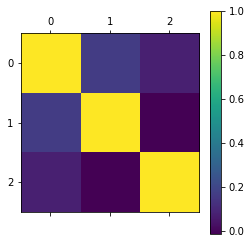

In [126]:
import matplotlib.pyplot as plt
plt.matshow(cross_matrix)
plt.colorbar()
plt.show()
#0:pacman
#1:videogame
#2:yellow

Lastly, it is possible to make use of dimensionality reduction algorithm to get a low-dimensional representation of our embedding vector space. In the following we use the TSNE algorithm, which preserves local distance of the points.

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()
viz_words = 50
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[500:500+viz_words, :])


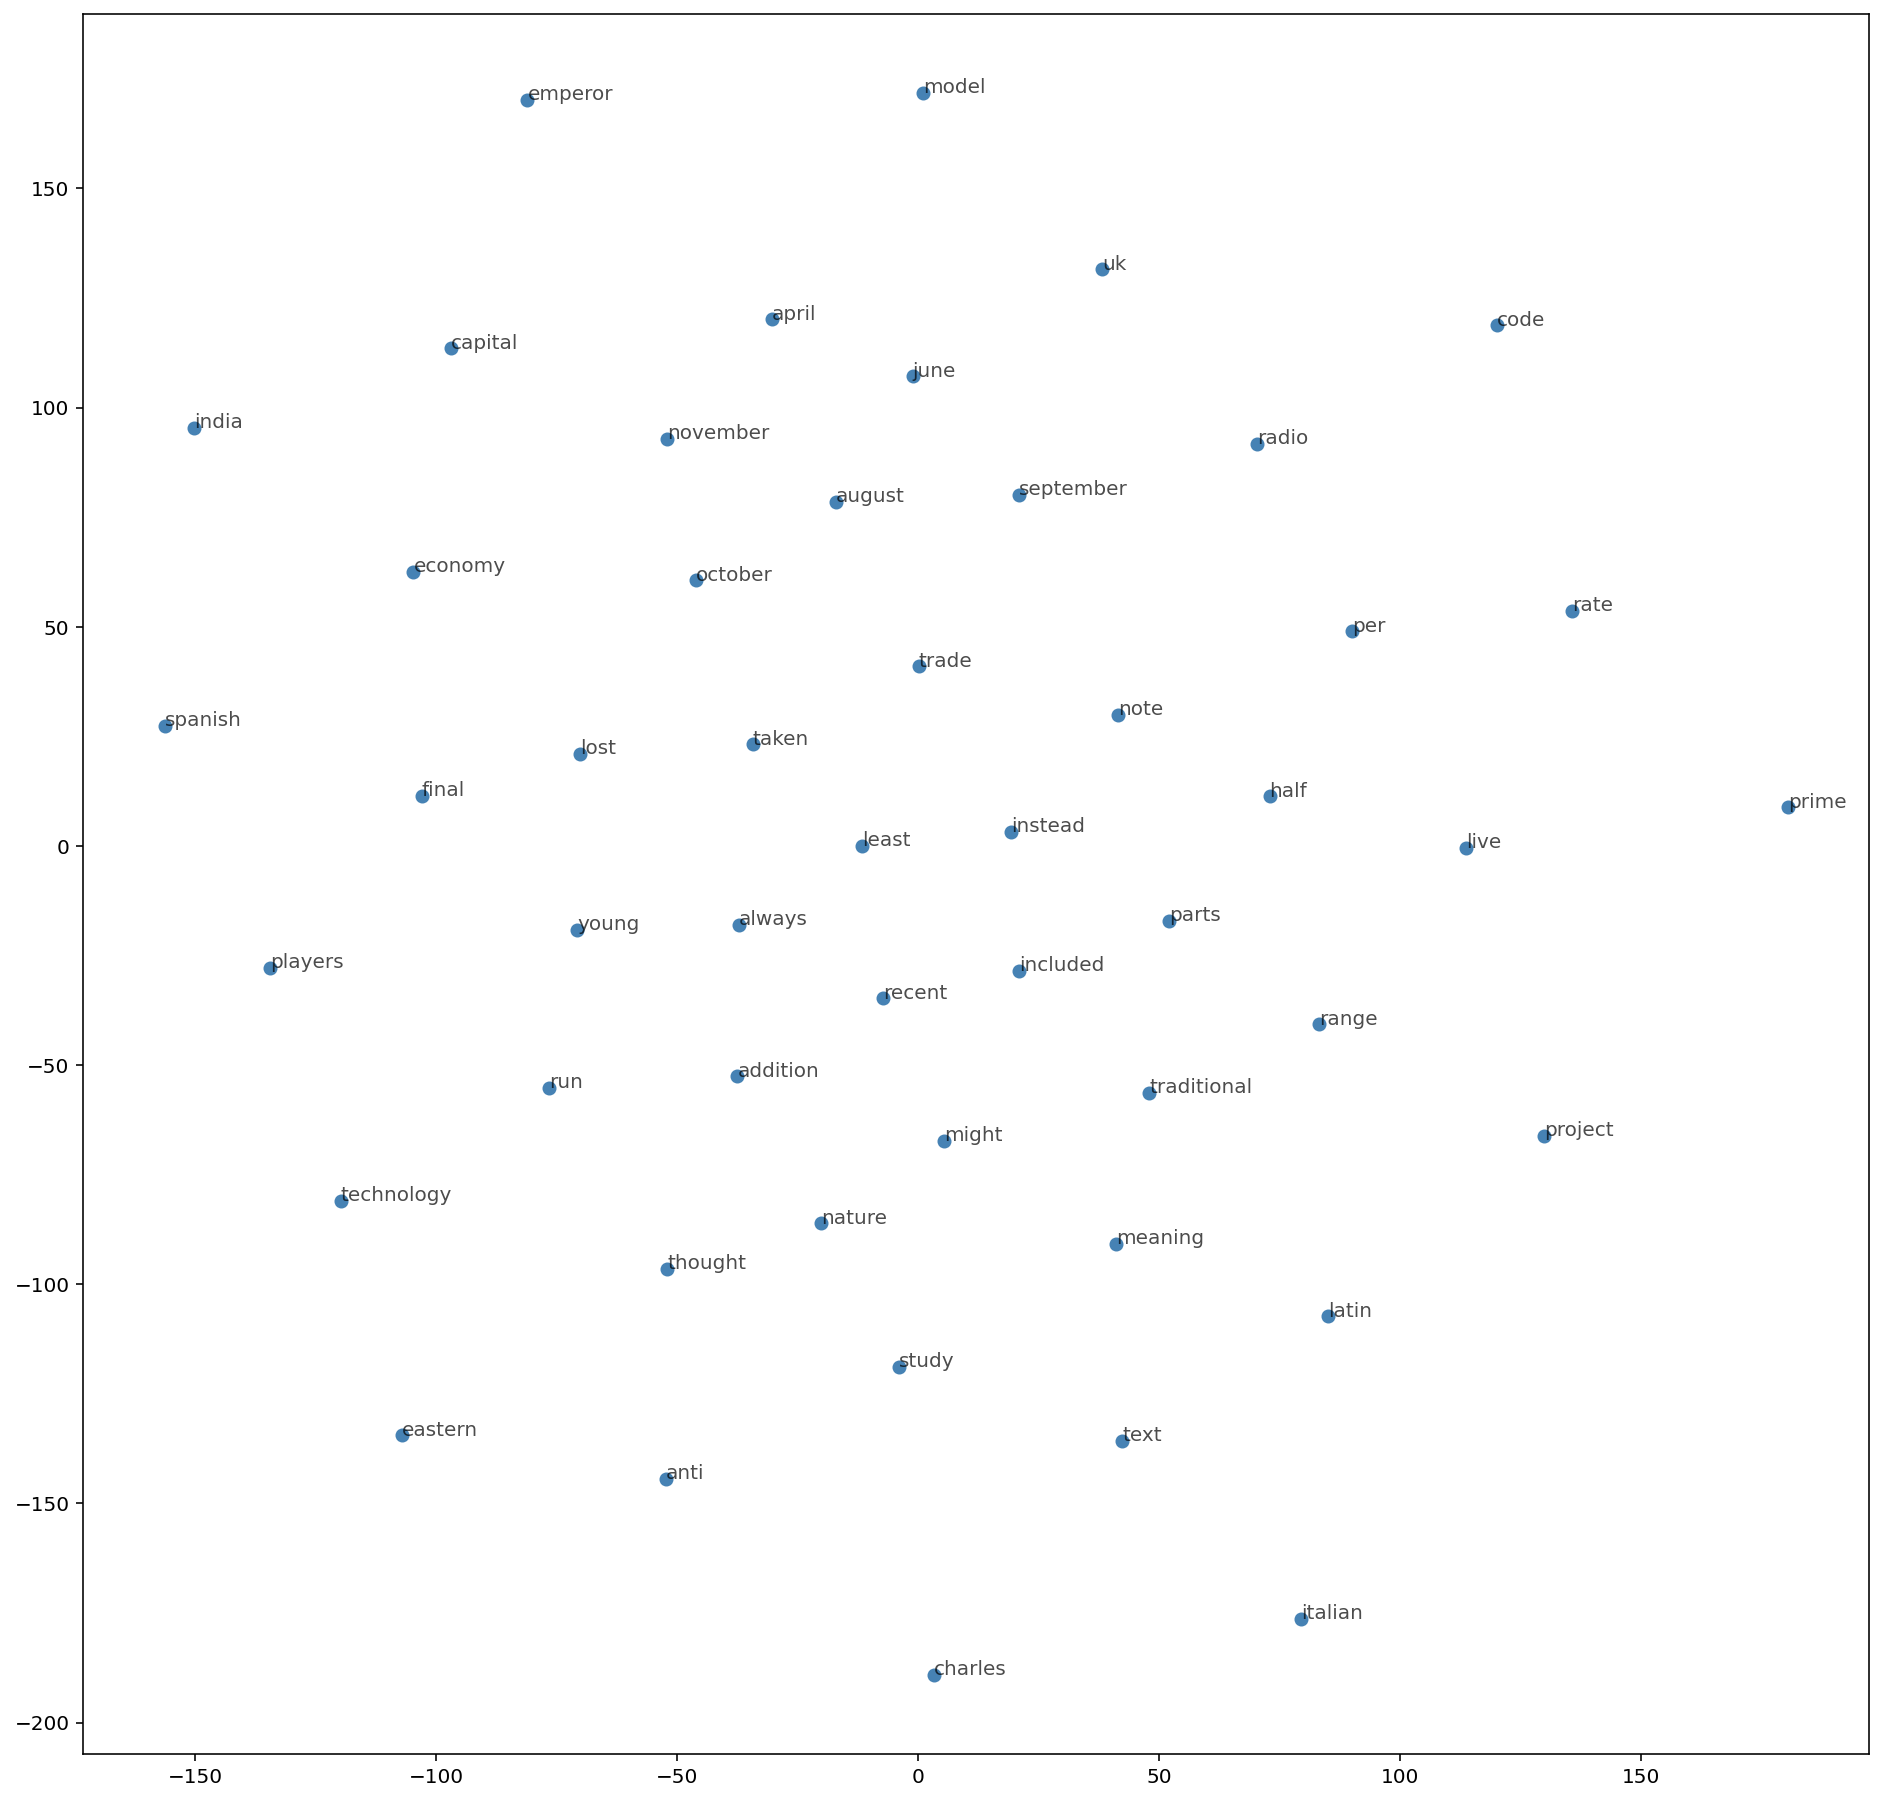

In [21]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[500+idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

## References

*  Mikolov T. et al., **Efficient Estimation of Word Representations in Vector Space**, 2013
*  Mikolov T. et al., **Distributed Representations of Words**, 2013
*  McCormick, C., **Word2Vec Tutorial - The Skip-Gram Model**,  (2016, April 19), retrieved from http://www.mccormickml.com
*  Rong X., **Word2Vec Parameter Learning Explained**, 2016